## Installing "standalone" Sherpa

For installation instructions, please follow the [Sherpa standalone documentation](http://cxc.cfa.harvard.edu/contrib/sherpa/) page. The notebook was done with using the 4.8.2 release of Sherpa, and relies on having some form of [anaconda](https://www.continuum.io/downloads) installed (either the full installation or Miniconda).

To make sure I don't overwrite any existing Python set up, I created a separate environment - which I called `notebook482` - for the installation (this step is not needed, but makes experimenting a bit easier). I also decided to install a few useful packages (versions shown below), and note that (**new to this release**), I can use Python 3.5:

    % conda create -n=notebook482 -c sherpa sherpa python=3.5 ipython-notebook astropy matplotlib scipy
    Fetching package metadata .........
    Solving package specifications: ..........

    ...
        astropy:          1.2.1-np111py35_0       
        ipython-notebook: 4.0.4-py35_0            
        matplotlib:       1.5.1-np111py35_0
        scipy:            0.18.1-np111py35_0
        sherpa:           4.8.2-py35_2      sherpa
    ...
    #
    # To activate this environment, use:
    # > source activate notebook482
    #
    # To deactivate this environment, use:
    # > source deactivate notebook482
    #

Since I do what I'm told, I follow this with

    % source activate notebook482
    % git clone https://github.com/DougBurke/sherpa-standalone-notebooks
    % cd sherpa-standalone-notebooks
    % jupyter notebook
    
and a page containing the following is now visible in my web browser:

![A list of notebooks is given, one of which is "simple sherpa fit"](images/notebook-start.png)

Selecting the "simple sherpa fit" option creates a new page containing this (user-editable) notebook, and the initial page changes to show that a notebook is running:

![The "simple sherpa fit" notebook is now marked as "running"](images/notebook-simple-running.png)

## The Sherpa UI

As Sherpa is a set of routines, there are several ways to use it. The main ones are

 1 using the `sherpa.astro.ui` module, which provides data management
   capabilities on top of the fitting routines
   
 2 a low-level API where for those times when the UI layer is not
   needed.

We start with a brief exploration of the UI layer, using it to replicate
the simple one-dimensional polynomial fits from the [Python for Astronomers
"Introduction to NumPy and SciPy"](http://python4astronomers.github.io/core/numpy_scipy.html)
guide. Although it is more involved than the original version, which
uses the NumPy `polyfit` and `polyval` routines to fit a polynomial,
it is not that much more work, and the advantage is that it is easy
to change the model to fit a different, perhaps more-complicated,
model.

We then follow with a run through of the same fit, this time using the
lower-level API.

To start with - and as a check that everything is okay - I load the Sherpa `ui` module:

In [1]:
from sherpa.astro import ui

Since Sherpa has several optional parts, warning messages will be displayed when some of the parts
are not available. This can mean a problem in the configuration, but in this case the Sherpa
package installed by conda does not include support for 
[XSPEC models](https://heasarc.gsfc.nasa.gov/xanadu/xspec/manual/Models.html), which is not
a concern for this notebook.

Note that in earlier versions of this notebook I used the following commands to reduce the amount of repeated
information displayed by some Sherpa commands; this is no-longer needed with recent IPython notebooks (I am not
sure exactly when this happened), so is no-longer needed:

    import logging
    import sys
    logging.getLogger('sherpa').propagate = 0
    sys.tracebacklimit = None

For this notebook I need to download and unpack the data from the
[Python for Astronomers](https://python4astronomers.github.io/core/numpy_scipy.html)
site; the following code is taken from that page (if you have problems following
along please review the page to see if the instructions have changed since I last updated
this notebook).

In [2]:
from astropy.extern.six.moves.urllib import request
import tarfile
url = 'http://python4astronomers.github.io/_downloads/core_examples.tar'
tarfile.open(fileobj=request.urlopen(url), mode='r|').extractall()

The data is in a subdirectory, so I take advantage of the IPython support for basic shell commands
and move there:

In [3]:
cd py4ast/core

/home/djburke/sherpa/sherpa-standalone-notebooks/py4ast/core


Now I can read in the data using the AstroPy FITS reader:

In [4]:
from astropy.io import fits
hdus = fits.open('3c120_stis.fits.gz')

Please see the 
[original guide](https://python4astronomers.github.io/core/numpy_scipy.html#read-in-the-2-d-image)
for information on what the following is doing:

In [5]:
primary = hdus[0].data  # Primary (NULL) header data unit
img = hdus[1].data      # Intensity data
err = hdus[2].data      # Error per pixel
dq = hdus[3].data       # Data quality per pixel

The following statement makes the matplotlib plots appear inline (and sets up the `plt` namespace):

In [6]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


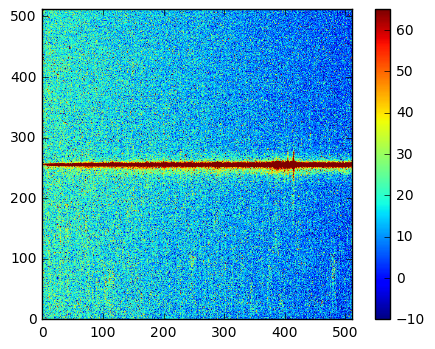

In [7]:
plt.imshow(img, origin = 'lower', vmin = -10, vmax = 65)
plt.colorbar()

It is this image that we are going to clean of cosmic rays (using SciPy) and to subtract a
simple estimate of the background (using Sherpa).

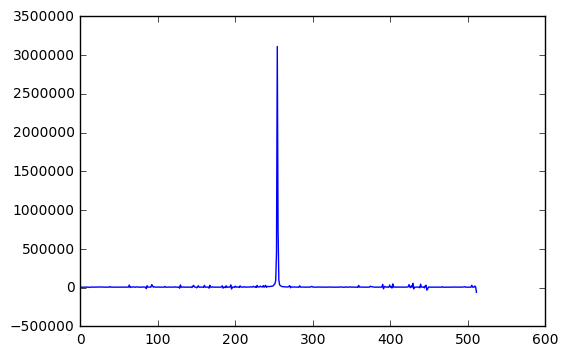

In [8]:
profile = img.sum(axis=1)
plt.figure()
plt.plot(profile)

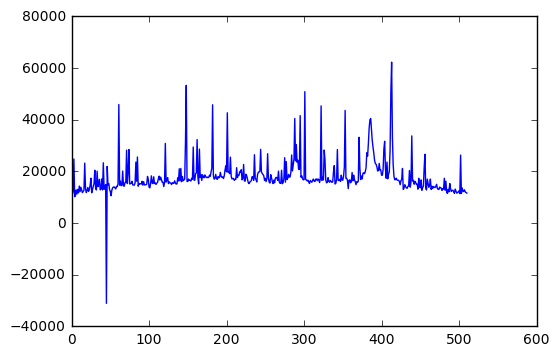

In [9]:
spectrum = img.sum(axis=0)
plt.figure()
plt.plot(spectrum)

Cosmic rays are removed using a simple median-filter approach:

In [10]:
import scipy.signal
img_sm = scipy.signal.medfilt(img, 5)
sigma = median(err)
bad = np.abs(img - img_sm) / sigma > 8.0
img_cr = img.copy()
img_cr[bad] = img_sm[bad]
img_cr[230:280,:] = img[230:280,:]  # Filter only for background

In [11]:
x = append(np.arange(10, 200), np.arange(300, 480))  # Background rows
y = img_cr[x, 10]         # Background rows of column 10 of cleaned image

I now "load" the data for the column into Sherpa, as dataset 1 (the `ui` layer of Sherpa handles
data management, using identifiers to refer to a particular dataset). The `load_arrays` command is
the only time here in which we will use the dataset identifier, since the default is to
either use dataset 1 or to use all loaded datasets (depending on the command).

Since we do not have errors here, we switch to the least-squares statistic, and then plot
up the data. Since Sherpa really wants to plot errors, it creates some for us and tells
us to ignore them; Ive never been happy with this behavior!

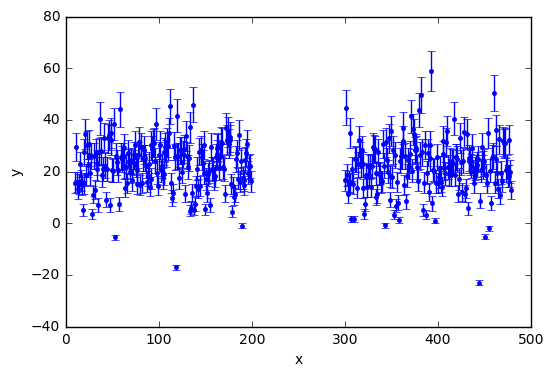

In [12]:
ui.load_arrays(1, x, y)
ui.set_stat('leastsq')
ui.plot_data()

The [original guide](https://python4astronomers.github.io/core/numpy_scipy.html#fit-the-background)
used a simple polynomial model to fit the data, so I will do the same. The syntax `ui.<modelname>.<instance name>` - e.g. `ui.polynom1d.mdl` - creates a variable called `<instance name>` (so `mdl` here) which is an instance of the model class (in this case a one-dimensional polynomial). It lets us "name" models, which can be useful in more-complicated scenarios, where the data has to be modelled as a combination of models. The `ui.set_source` call associates a model expression with a dataset (if not given it defaults to the default dataset).

In [13]:
ui.set_source(ui.polynom1d.mdl)

The model instance can be printed out, which shows its parameters:

In [14]:
print(mdl)

polynom1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.c0       thawed            1 -3.40282e+38  3.40282e+38           
   mdl.c1       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c2       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c3       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c4       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c5       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c6       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c7       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c8       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.offset   frozen            0 -3.40282e+38  3.40282e+38           


## Model documentation is now available

One addition in the 4.8.2 release is that the model documentation is now included, so `help(<instance name>)` should now provide information on what the parameters means (as well as a lot of other information!).

In [15]:
help(mdl)

Help on Polynom1D in module sherpa.models.basic object:

class Polynom1D(sherpa.models.model.ArithmeticModel)
 |  One-dimensional polynomial function of order 8.
 |  
 |  The maximum order of the polynomial is 8. The default setting has
 |  all parameters frozen except for ``c0``, which means that the
 |  model acts as a constant.
 |  
 |  Attributes
 |  ----------
 |  c0
 |      The constant term.
 |  c1
 |      The amplitude of the (x-offset) term.
 |  c2
 |      The amplitude of the (x-offset)^2 term.
 |  c3
 |      The amplitude of the (x-offset)^3 term.
 |  c4
 |      The amplitude of the (x-offset)^4 term.
 |  c5
 |      The amplitude of the (x-offset)^5 term.
 |  c6
 |      The amplitude of the (x-offset)^6 term.
 |  c7
 |      The amplitude of the (x-offset)^7 term.
 |  c8
 |      The amplitude of the (x-offset)^8 term.
 |  offset
 |      There is a degeneracy between ``c0`` and ``offset``, so it
 |      is recommended that at least one of these remains frozen.
 |  
 |  
 |  Se

Note that the `Type` field above has `thawed` only for one parameter - `c0` - which is not sufficient here,
as we want to fit the slope and not just the overall normalization. We therefore use the `thaw` command
to tell Sherpa that the `c1` parameter should also be fit.

The `guess` command tries to set the model parameters to something sensible: in most
cases this is limited to a change in normalization, but you can also see that the range of
the thawed parameters has also been changed here.

In [16]:
ui.thaw(mdl.c1)
ui.guess(mdl)
print(mdl)

polynom1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.c0       thawed      17.9139     -23.0992      58.9271           
   mdl.c1       thawed            0     -17.4896      17.4896           
   mdl.c2       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c3       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c4       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c5       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c6       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c7       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c8       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.offset   frozen            0 -3.40282e+38  3.40282e+38           


The `plot_fit` command displays the data and the current model (even if no fit has been made):

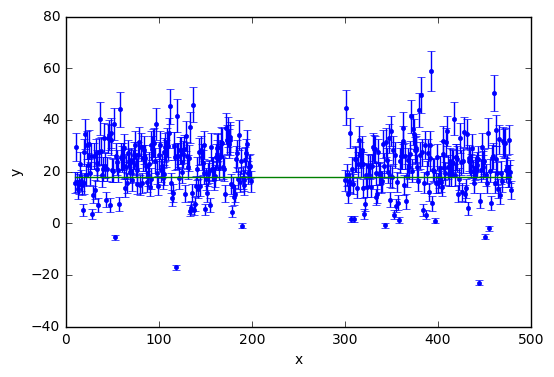

In [17]:
ui.plot_fit()

In this case the fit is very quick:

In [18]:
ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 41778.4
Final fit statistic   = 36134.3 at function evaluation 6
Data points           = 370
Degrees of freedom    = 368
Change in statistic   = 5644.1
   mdl.c0         22.3585     
   mdl.c1         -0.00227968 


The `plot_fit_resid` command displays the data and best-fit in the top plot, and "data - best-fit"
in the bottom plot.

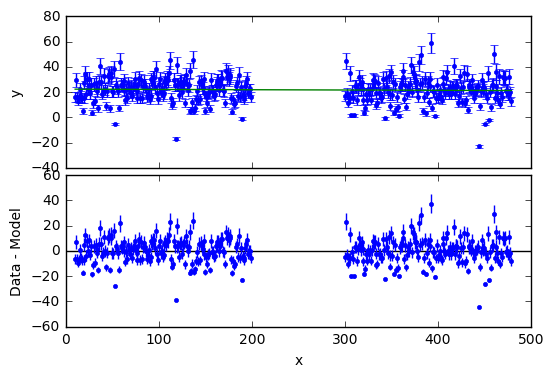

In [19]:
ui.plot_fit_resid()

Note that the model parameters have been updated by the `fit` command:

In [20]:
print(mdl)

polynom1d.mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.c0       thawed      22.3585     -23.0992      58.9271           
   mdl.c1       thawed  -0.00227968     -17.4896      17.4896           
   mdl.c2       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c3       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c4       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c5       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c6       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c7       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c8       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.offset   frozen            0 -3.40282e+38  3.40282e+38           


Since we are going to loop through each column, performing a fit, the screen
output from the `fit` command will be overwhelming, and not very useful.
So we hide it:

In [21]:
import logging
logger = logging.getLogger('sherpa')
print(logger.level)
print(logger.level == logging.INFO)
logger.level = logging.WARN

20
True


The following is a copy of the code from the original guide, but using Sherpa for the
fit and model evaluation. Note that you can evaluate a model component - such as `mdl` - on
an arbitrary grid (in this case `xrows`).

The `out0` and `out1` arrays are used to store the best-fit parameters for each
column; a better approach would be to allocate a numpy array and fill it up
rather than use a Python list, but it doesn't make much difference in this case!

In [22]:
xrows = np.arange(img_cr.shape[0])          # Array from 0 .. N_rows-1
bkg = np.zeros_like(img_cr)                 # Empty image for background fits
out0 = []                                   # Store the best-fit values
out1 = []
for col in np.arange(img_cr.shape[1]):      # Iterate over columns
    ui.load_arrays(1, x, img_cr[x, col])
    # note: in this case use the previous best-fit value as
    # a starting point for the next fit; really should be
    # resetting the values to be safe, although in this case
    # we may expect the fit values to be similar
    ui.fit()
    out0.append(mdl.c0.val)                 # Use .val to get at the numeric value
    out1.append(mdl.c1.val)
    bkg[:, col] = mdl(xrows)                # Evaluate the model for all rows

Before doing anything else, let's restore the default Sherpa logging level,
in case we use anything later on in this notebook:

In [23]:
logger.level = logging.INFO

Out of interest, let's see how the model parameter values vary by column and against each other:

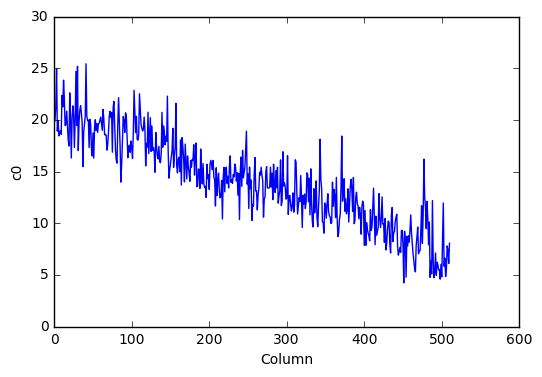

In [24]:
plt.plot(out0)
plt.xlabel('Column')
plt.ylabel('c0')

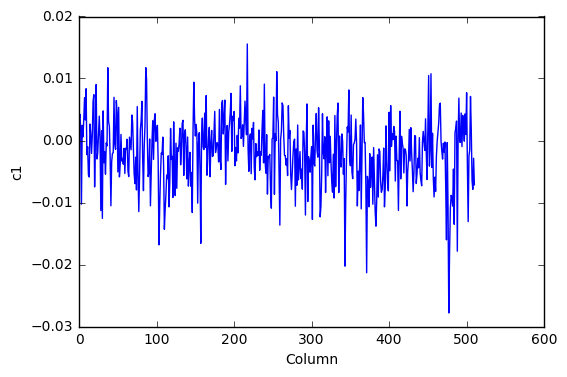

In [25]:
plt.plot(out1)
plt.xlabel('Column')
plt.ylabel('c1')

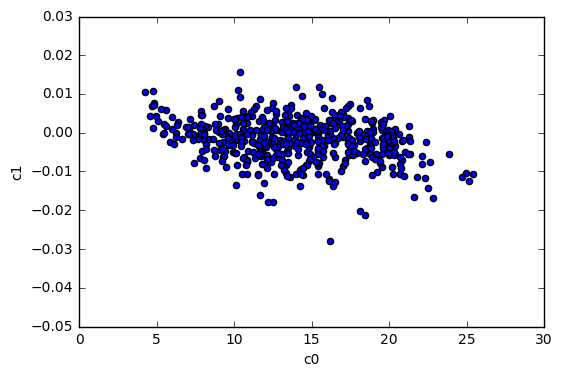

In [26]:
plt.scatter(out0, out1)
plt.xlabel('c0')
plt.ylabel('c1')

As expected, the normalization values are correlated, whereas it's not so obvious for the slope.

How does the background-subtracted version compare to the original guide? Well, the following plots show they are similar,
but I have not done a close comparison to see how much difference there is.

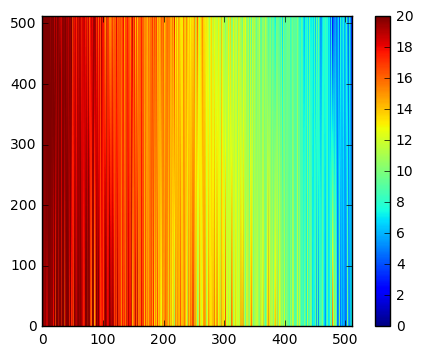

In [27]:
plt.imshow(bkg, origin = 'lower', vmin=0, vmax=20)
plt.colorbar()

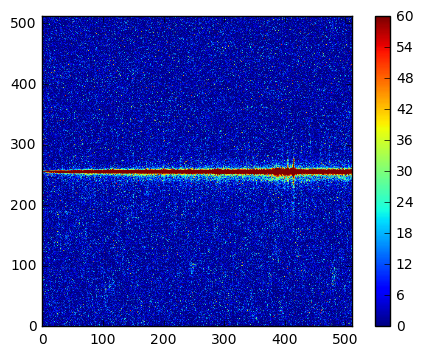

In [28]:
img_bkg = img_cr - bkg
plt.clf()
plt.imshow(img_bkg, origin = 'lower', vmin=0, vmax=60)
plt.colorbar()

The result can be compared to that obtained on the
[Python 4 Astronomers](https://python4astronomers.github.io/core/numpy_scipy.html#sum-the-source-signal)
page:

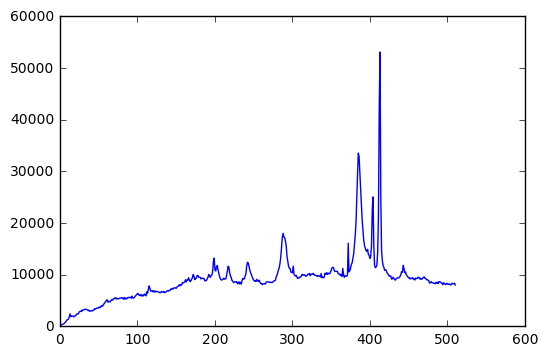

In [29]:
spectrum = img_bkg[250:260, :].sum(axis=0)
plt.plot(spectrum)

## The low-level Sherpa API

How about using the low-level API, as discussed in http://python4astronomers.github.io/fitting/low-level.html? Unlike
the `ui` layer, the data management here is explicit (i.e. I have to explicitly state what data is being used with that model and statistic when I perform a fit).

First, load in the parts of the API we are going to use, using a mixture of module imports and importing specific symbols:

In [30]:
from sherpa.data import Data1D
from sherpa.optmethods import LevMar
from sherpa.fit import Fit
from sherpa import models
from sherpa import stats

I reset the `x` and `y` variables to match the values used in the original fit above and use it
to create a `Data1D` object (the `ui.load_arrays` command also does this, but we don't see this unless
a routine like `ui.get_data` is used):

In [31]:
x = append(np.arange(10, 200), np.arange(300, 480))
y = img_cr[x, 10]
data = Data1D('row', x, y)

In [32]:
print(data)

name      = row
x         = Int64[370]
y         = Float32[370]
staterror = None
syserror  = None


In this case we do not use the error information since we are going to use
the `stats.LeastSq` least-squares statistic in the fit. Before we can fit,
we need a model:

In [33]:
mdl = models.Polynom1D('mdl')
mdl.c1.thaw()

In [34]:
print(mdl)

mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.c0       thawed            1 -3.40282e+38  3.40282e+38           
   mdl.c1       thawed            0 -3.40282e+38  3.40282e+38           
   mdl.c2       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c3       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c4       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c5       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c6       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c7       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c8       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.offset   frozen            0 -3.40282e+38  3.40282e+38           


Help on the model can be found by saying

    help(mdl)
    
but, as shown earlier, it's quite long so I won't repeat the information here.

Now that we have the data to fit, a model for the data, we can set up the fit
by also specifying the statistic and optimizer:

In [35]:
f = Fit(data, mdl, stats.LeastSq(), LevMar())

This has not actually run the fit yet; first we look at the `Fit` object:

In [36]:
print(f)

data      = row
model     = mdl
stat      = LeastSq
method    = LevMar
estmethod = Covariance


To fit the data we use the `fit` method and store the result, which contains information on whether
the fit succeeded and the model parameters; it is the same object as returned by 
`sherpa.astro.ui.fit`, seen above:

In [37]:
result = f.fit()

In [38]:
print(result)

datasets       = None
itermethodname = none
methodname     = levmar
statname       = leastsq
succeeded      = True
parnames       = ('mdl.c0', 'mdl.c1')
parvals        = (22.358465116131068, -0.0022796841763203391)
statval        = 36134.299138144015
istatval       = 196319.69620159388
dstatval       = 160185.397063
numpoints      = 370
dof            = 368
qval           = None
rstat          = None
message        = successful termination
nfev           = 6


Note that the model has also been updated, so you can get the best-fit values
from either `result` or `mdl`:

In [39]:
print(mdl)

mdl
   Param        Type          Value          Min          Max      Units
   -----        ----          -----          ---          ---      -----
   mdl.c0       thawed      22.3585 -3.40282e+38  3.40282e+38           
   mdl.c1       thawed  -0.00227968 -3.40282e+38  3.40282e+38           
   mdl.c2       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c3       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c4       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c5       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c6       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c7       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.c8       frozen            0 -3.40282e+38  3.40282e+38           
   mdl.offset   frozen            0 -3.40282e+38  3.40282e+38           


Although we did not use the `guess` method here we get the same results
as with the `ui` version: $c_0 \sim 22.4$ and $c_1 \sim 0$.

Note that one difference is that the low-level interface does not attach
the Sherpa logging instance, so there is no screen output by default
here.

We can then fit the image using a similar loop as previously:

In [40]:
xrows = np.arange(img_cr.shape[0])
nbkg = np.zeros_like(img_cr)
nout0 = []
nout1 = []
for col in np.arange(img_cr.shape[1]):
    d = Data1D('col', x, img_cr[x, col])
    res = Fit(d, mdl, stats.LeastSq(), LevMar()).fit()
    nout0.append(mdl.c0.val)
    nout1.append(mdl.c1.val)
    nbkg[:, col] = mdl(xrows)

And a quick comparison of the results to show that they are essentially the same; the differences are very small, due to the fits not necessarily starting off from exactly the same place.

In [41]:
diff = bkg - nbkg

In [42]:
print("Max diff = {}".format(diff.max()))
print("Min diff = {}".format(diff.min()))

Max diff = 9.5367431640625e-07
Min diff = -9.5367431640625e-07


In [43]:
d0 = np.asarray(out0) - np.asarray(nout0)
print("Max difference for c0 = {}".format(d0.max()))
print("   % difference       = {}".format((100*d0/np.asarray(out0)).max()))

Max difference for c0 = 2.2940280786087897e-09
   % difference       = 4.8762350080056924e-08
